In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgb
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

In [2]:
user = pd.read_csv('takehome_users.csv', encoding_errors='ignore')
user

object_id        creation_time               name  \
0              1  2014-04-22 03:53:30     Clausen August   
1              2  2013-11-15 03:45:04      Poole Matthew   
2              3  2013-03-19 23:14:52  Bottrill Mitchell   
3              4  2013-05-21 08:09:28    Clausen Nicklas   
4              5  2013-01-17 10:14:20          Raw Grace   
...          ...                  ...                ...   
11995      11996  2013-09-06 06:14:15       Meier Sophia   
11996      11997  2013-01-10 18:28:37      Fisher Amelie   
11997      11998  2014-04-27 12:45:16        Haynes Jake   
11998      11999  2012-05-31 11:55:59       Faber Annett   
11999      12000  2014-01-26 08:57:12          Lima Thas   

                            email     creation_source  \
0        AugustCClausen@yahoo.com        GUEST_INVITE   
1          MatthewPoole@gustr.com          ORG_INVITE   
2      MitchellBottrill@gustr.com          ORG_INVITE   
3       NicklasSClausen@yahoo.com        GUEST_INVITE   
4              GraceRaw@yahoo.com        GUEST_INVITE   
...                           ...                 ...   
11995       SophiaMeier@gustr.com          ORG_INVITE   
11996      AmelieFisher@gmail.com  SIGNUP_GOOGLE_AUTH   
11997         JakeHaynes@cuvox.de        GUEST_INVITE   
11998          mhaerzxp@iuxiw.com   PERSONAL_PROJECTS   
11999   ThaisMeloLima@hotmail.com              SIGNUP   

       last_session_creation_time  opted_in_to_mailing_list  \
0                    1.398139e+09                         1   
1                    1.396238e+09                         0   
2                    1.363735e+09                         0   
3                    1.369210e+09                         0   
4                    1.358850e+09                         0   
...                           ...                       ...   
11995                1.378448e+09                         0   
11996                1.358275e+09                         0   
11997                1.398603e+09                         1   
11998                1.338638e+09                         0   
11999                1.390727e+09                         0   

       enabled_for_marketing_drip  org_id  invited_by_user_id  
0                               0      11             10803.0  
1                               0       1               316.0  
2                               0      94              1525.0  
3                               0       1              5151.0  
4                               0     193              5240.0  
...                           ...     ...                 ...  
11995                           0      89              8263.0  
11996                           0     200                 NaN  
11997                           1      83              8074.0  
11998                           0       6                 NaN  
11999                           1       0                 NaN  

[12000 rows x 10 columns]

In [3]:
user.creation_time = pd.to_datetime(user.creation_time)
user.last_session_creation_time = pd.to_datetime(user.last_session_creation_time, unit='s')

In [4]:
user.head()

object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE        2014-04-22 03:53:30   
1      MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
2  MitchellBottrill@gustr.com      ORG_INVITE        2013-03-19 23:14:52   
3   NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
4          GraceRaw@yahoo.com    GUEST_INVITE        2013-01-22 10:14:20   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0                           0       1   
4                         0                           0     193   

   invited_by_user_id  
0             10803.0  
1               316.0  
2              1525.0  
3              5151.0  
4              5240.0

In [5]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


Some nulls on last_session_creation_time and invited_by_user_id.

In [6]:
user['length'] = (user.last_session_creation_time-user.creation_time).dt.days
user.length = user.length.fillna(0)

In [7]:
user.describe().T

count                           mean  \
object_id                   12000.0                         6000.5   
creation_time                 12000  2013-07-16 13:25:32.964499968   
last_session_creation_time     8823  2013-09-15 21:08:25.700441856   
opted_in_to_mailing_list    12000.0                         0.2495   
enabled_for_marketing_drip  12000.0                       0.149333   
org_id                      12000.0                     141.884583   
invited_by_user_id           6417.0                    5962.957145   
length                      12000.0                      43.543083   

                                            min  \
object_id                                   1.0   
creation_time               2012-05-31 00:43:27   
last_session_creation_time  2012-05-31 08:20:06   
opted_in_to_mailing_list                    0.0   
enabled_for_marketing_drip                  0.0   
org_id                                      0.0   
invited_by_user_id                          3.0   
length                                      0.0   

                                                      25%  \
object_id                                         3000.75   
creation_time               2013-01-15 21:28:22.750000128   
last_session_creation_time            2013-03-13 17:16:05   
opted_in_to_mailing_list                              0.0   
enabled_for_marketing_drip                            0.0   
org_id                                               29.0   
invited_by_user_id                                 3058.0   
length                                                0.0   

                                                   50%  \
object_id                                       6000.5   
creation_time               2013-08-05 21:35:19.500000   
last_session_creation_time         2013-10-27 15:41:10   
opted_in_to_mailing_list                           0.0   
enabled_for_marketing_drip                         0.0   
org_id                                           108.0   
invited_by_user_id                              5954.0   
length                                             0.0   

                                                      75%  \
object_id                                         9000.25   
creation_time               2014-01-28 10:20:12.249999872   
last_session_creation_time            2014-04-25 16:16:44   
opted_in_to_mailing_list                              0.0   
enabled_for_marketing_drip                            0.0   
org_id                                             238.25   
invited_by_user_id                                 8817.0   
length                                                3.0   

                                            max          std  
object_id                               12000.0   3464.24595  
creation_time               2014-05-30 23:59:19          NaN  
last_session_creation_time  2014-06-06 14:58:50          NaN  
opted_in_to_mailing_list                    1.0     0.432742  
enabled_for_marketing_drip                  1.0     0.356432  
org_id                                    416.0   124.056723  
invited_by_user_id                      11999.0  3383.761968  
length                                    729.0   126.352426

In [8]:
user.describe(include='object').T

count unique                  top  freq
name             12000  11349    Cavalcanti Victor     5
email            12000  11980  AlfieLane@yahoo.com     2
creation_source  12000      5           ORG_INVITE  4254

There is a lot of duplicated names and some duplicated emails.

In [9]:
user.duplicated(['name', 'email']).any()

True

In [10]:
user.duplicated().any()

False

There are both name and email duplicates but no complete duplicated rows.

In [11]:
engage = pd.read_csv('takehome_user_engagement.csv')
engage

time_stamp  user_id  visited
0       2014-04-22 03:53:30        1        1
1       2013-11-15 03:45:04        2        1
2       2013-11-29 03:45:04        2        1
3       2013-12-09 03:45:04        2        1
4       2013-12-25 03:45:04        2        1
...                     ...      ...      ...
207912  2013-09-06 06:14:15    11996        1
207913  2013-01-15 18:28:37    11997        1
207914  2014-04-27 12:45:16    11998        1
207915  2012-06-02 11:55:59    11999        1
207916  2014-01-26 08:57:12    12000        1

[207917 rows x 3 columns]

In [12]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


No nulls.

In [13]:
engage.describe().T

count         mean          std  min     25%     50%     75%  \
user_id  207917.0  5913.314197  3394.941674  1.0  3087.0  5682.0  8944.0   
visited  207917.0     1.000000     0.000000  1.0     1.0     1.0     1.0   

             max  
user_id  12000.0  
visited      1.0

In [14]:
engage.describe(include='object').T

count  unique                  top freq
time_stamp  207917  207220  2013-04-06 21:21:37    2

In [15]:
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp')

In [16]:
(engage.groupby('user_id').rolling('1D').sum()>1).any()

visited    False
dtype: bool

No daily multiple visit.

In [17]:
# total number of visit of each user
total_visit = engage.groupby('user_id', as_index=False).sum()

In [18]:
user = user.merge(total_visit, how='left', left_on='object_id', right_on='user_id').fillna({'visited':0})

In [19]:
adopted = engage.groupby('user_id', as_index=False).rolling('7D').sum().query('visited>=3').user_id.unique()

adopted user = users who have more than 3 visits in 7 days period

In [20]:
user['adopted'] = [1 if i in adopted else 0 for i in user.object_id]

adopted=1 , otherwise=0

In [21]:
user.head()

object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE        2014-04-22 03:53:30   
1      MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
2  MitchellBottrill@gustr.com      ORG_INVITE        2013-03-19 23:14:52   
3   NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
4          GraceRaw@yahoo.com    GUEST_INVITE        2013-01-22 10:14:20   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0                           0       1   
4                         0                           0     193   

   invited_by_user_id  length  user_id  visited  adopted  
0             10803.0     0.0      1.0      1.0        0  
1               316.0   136.0      2.0     14.0        1  
2              1525.0     0.0      3.0      1.0        0  
3              5151.0     1.0      4.0      1.0        0  
4              5240.0     5.0      5.0      1.0        0

In [22]:
df = user.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'user_id'], axis=1)

In [23]:
df[['org_id', 'invited_by_user_id']] = df[['org_id', 'invited_by_user_id']].astype('object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  object 
 4   invited_by_user_id          6417 non-null   object 
 5   length                      12000 non-null  float64
 6   visited                     12000 non-null  float64
 7   adopted                     12000 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 750.1+ KB


In [25]:
df.describe()

opted_in_to_mailing_list  enabled_for_marketing_drip        length  \
count              12000.000000                12000.000000  12000.000000   
mean                   0.249500                    0.149333     43.543083   
std                    0.432742                    0.356432    126.352426   
min                    0.000000                    0.000000      0.000000   
25%                    0.000000                    0.000000      0.000000   
50%                    0.000000                    0.000000      0.000000   
75%                    0.000000                    0.000000      3.000000   
max                    1.000000                    1.000000    729.000000   

            visited       adopted  
count  12000.000000  12000.000000  
mean      17.326417      0.133500  
std       64.287839      0.340128  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      0.000000  
max      606.000000      1.000000

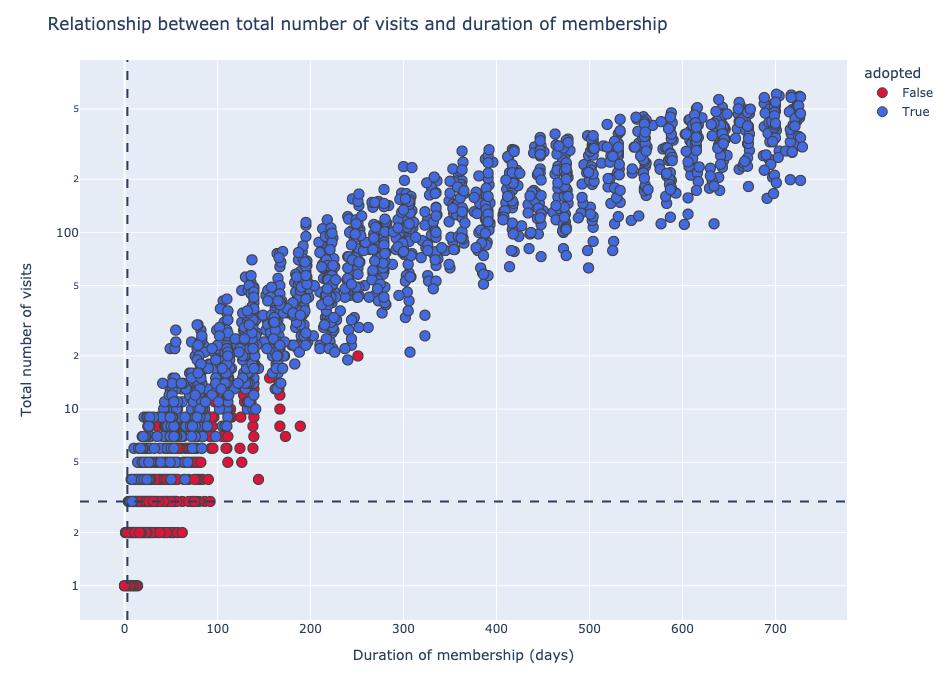

In [26]:
custom_colors = {1: "royalblue", 0: "crimson"}
fig = px.scatter(df, x='length', y='visited', color=df.adopted.astype('boolean'), log_y=True, 
                 color_discrete_map=custom_colors, labels={'color':'adopted'})
fig.update_traces(marker={'size':10, 'line':{'width':1}})
fig.add_vline(x=3, line={'dash':'dash'})
fig.add_hline(y=3, line={'dash':'dash'})
fig.update_xaxes(title='Duration of membership (days)')
fig.update_yaxes(title='Total number of visits')
fig.update_layout(template='plotly', width=950, height=700, title='Relationship between total number of visits and duration of membership')
fig.show('png')

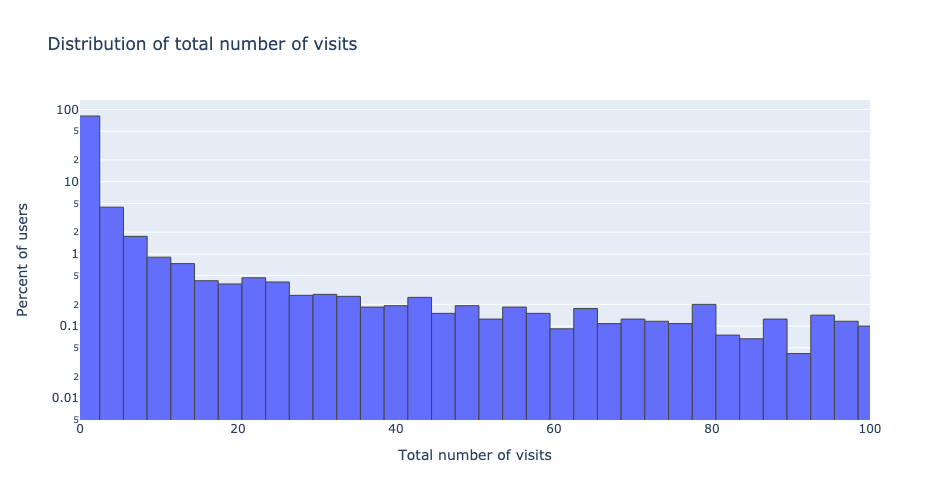

In [27]:
fig = go.Figure()
trace = go.Histogram(x=df.visited, xbins=dict(size=3), histnorm='percent', autobinx=False)
fig.add_trace(trace)
fig.update_traces(marker={'line':{'width':1}})
fig.update_xaxes(title='Total number of visits')
fig.update_yaxes(title='Percent of users')
fig.update_layout(xaxis_range=[0, 100], yaxis_type="log", title='Distribution of total number of visits', 
                  width=950, height=500, barmode='overlay', showlegend=False)
fig.show('png')

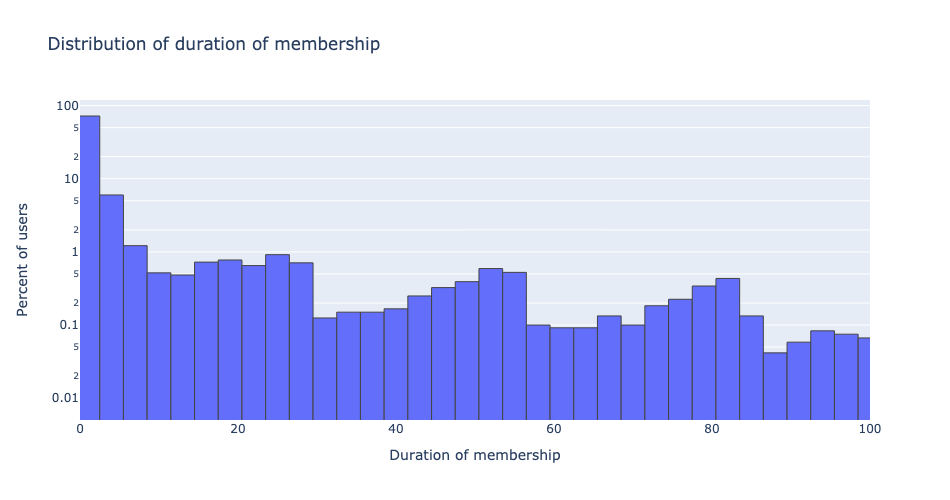

In [28]:
fig = go.Figure()
trace = go.Histogram(x=df.length, xbins=dict(size=3), histnorm='percent', autobinx=False)
fig.add_trace(trace)
fig.update_traces(marker={'line':{'width':1}})
fig.update_xaxes(title='Duration of membership')
fig.update_yaxes(title='Percent of users')
fig.update_layout(xaxis_range=[0, 100], yaxis_type="log", title='Distribution of duration of membership', 
                  width=950, height=500, showlegend=False)
fig.show('png')

In [29]:
df = df.loc[(df.visited>=3) & (df.length>=3)]

In [30]:
df['freq'] = df.visited/df.length

In [31]:
df.freq

1        0.102941
9        0.564612
19       0.083333
32       0.222222
41       0.610714
           ...   
11974    0.508235
11979    0.106667
11980    0.142857
11987    0.384615
11990    0.125000
Name: freq, Length: 2248, dtype: float64

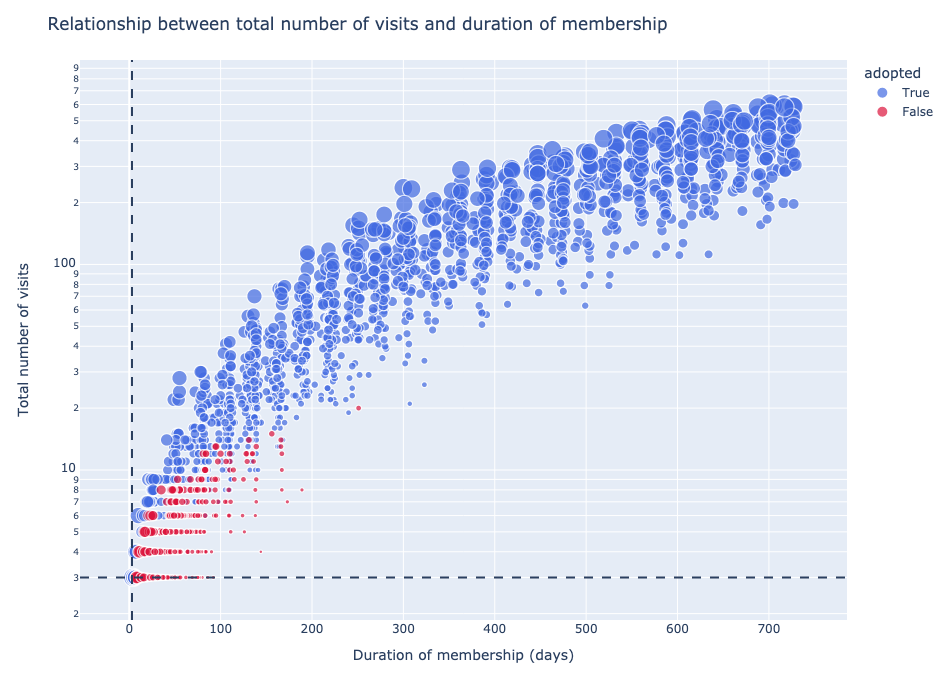

In [32]:
custom_colors = {1: "royalblue", 0: "crimson"}
fig = px.scatter(df, x='length', y='visited', color=df.adopted.astype('boolean'), size='freq',log_y=True, 
                 color_discrete_map=custom_colors, labels={'color':'adopted'})
fig.update_traces(marker={'line':{'width':1}})
fig.add_vline(x=3, line={'dash':'dash'})
fig.add_hline(y=3, line={'dash':'dash'})
fig.update_xaxes(title='Duration of membership (days)')
fig.update_yaxes(title='Total number of visits')
fig.update_layout(template='plotly', width=950, height=700, title='Relationship between total number of visits and duration of membership')
fig.show('png')

/Users/thanutrazhang/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



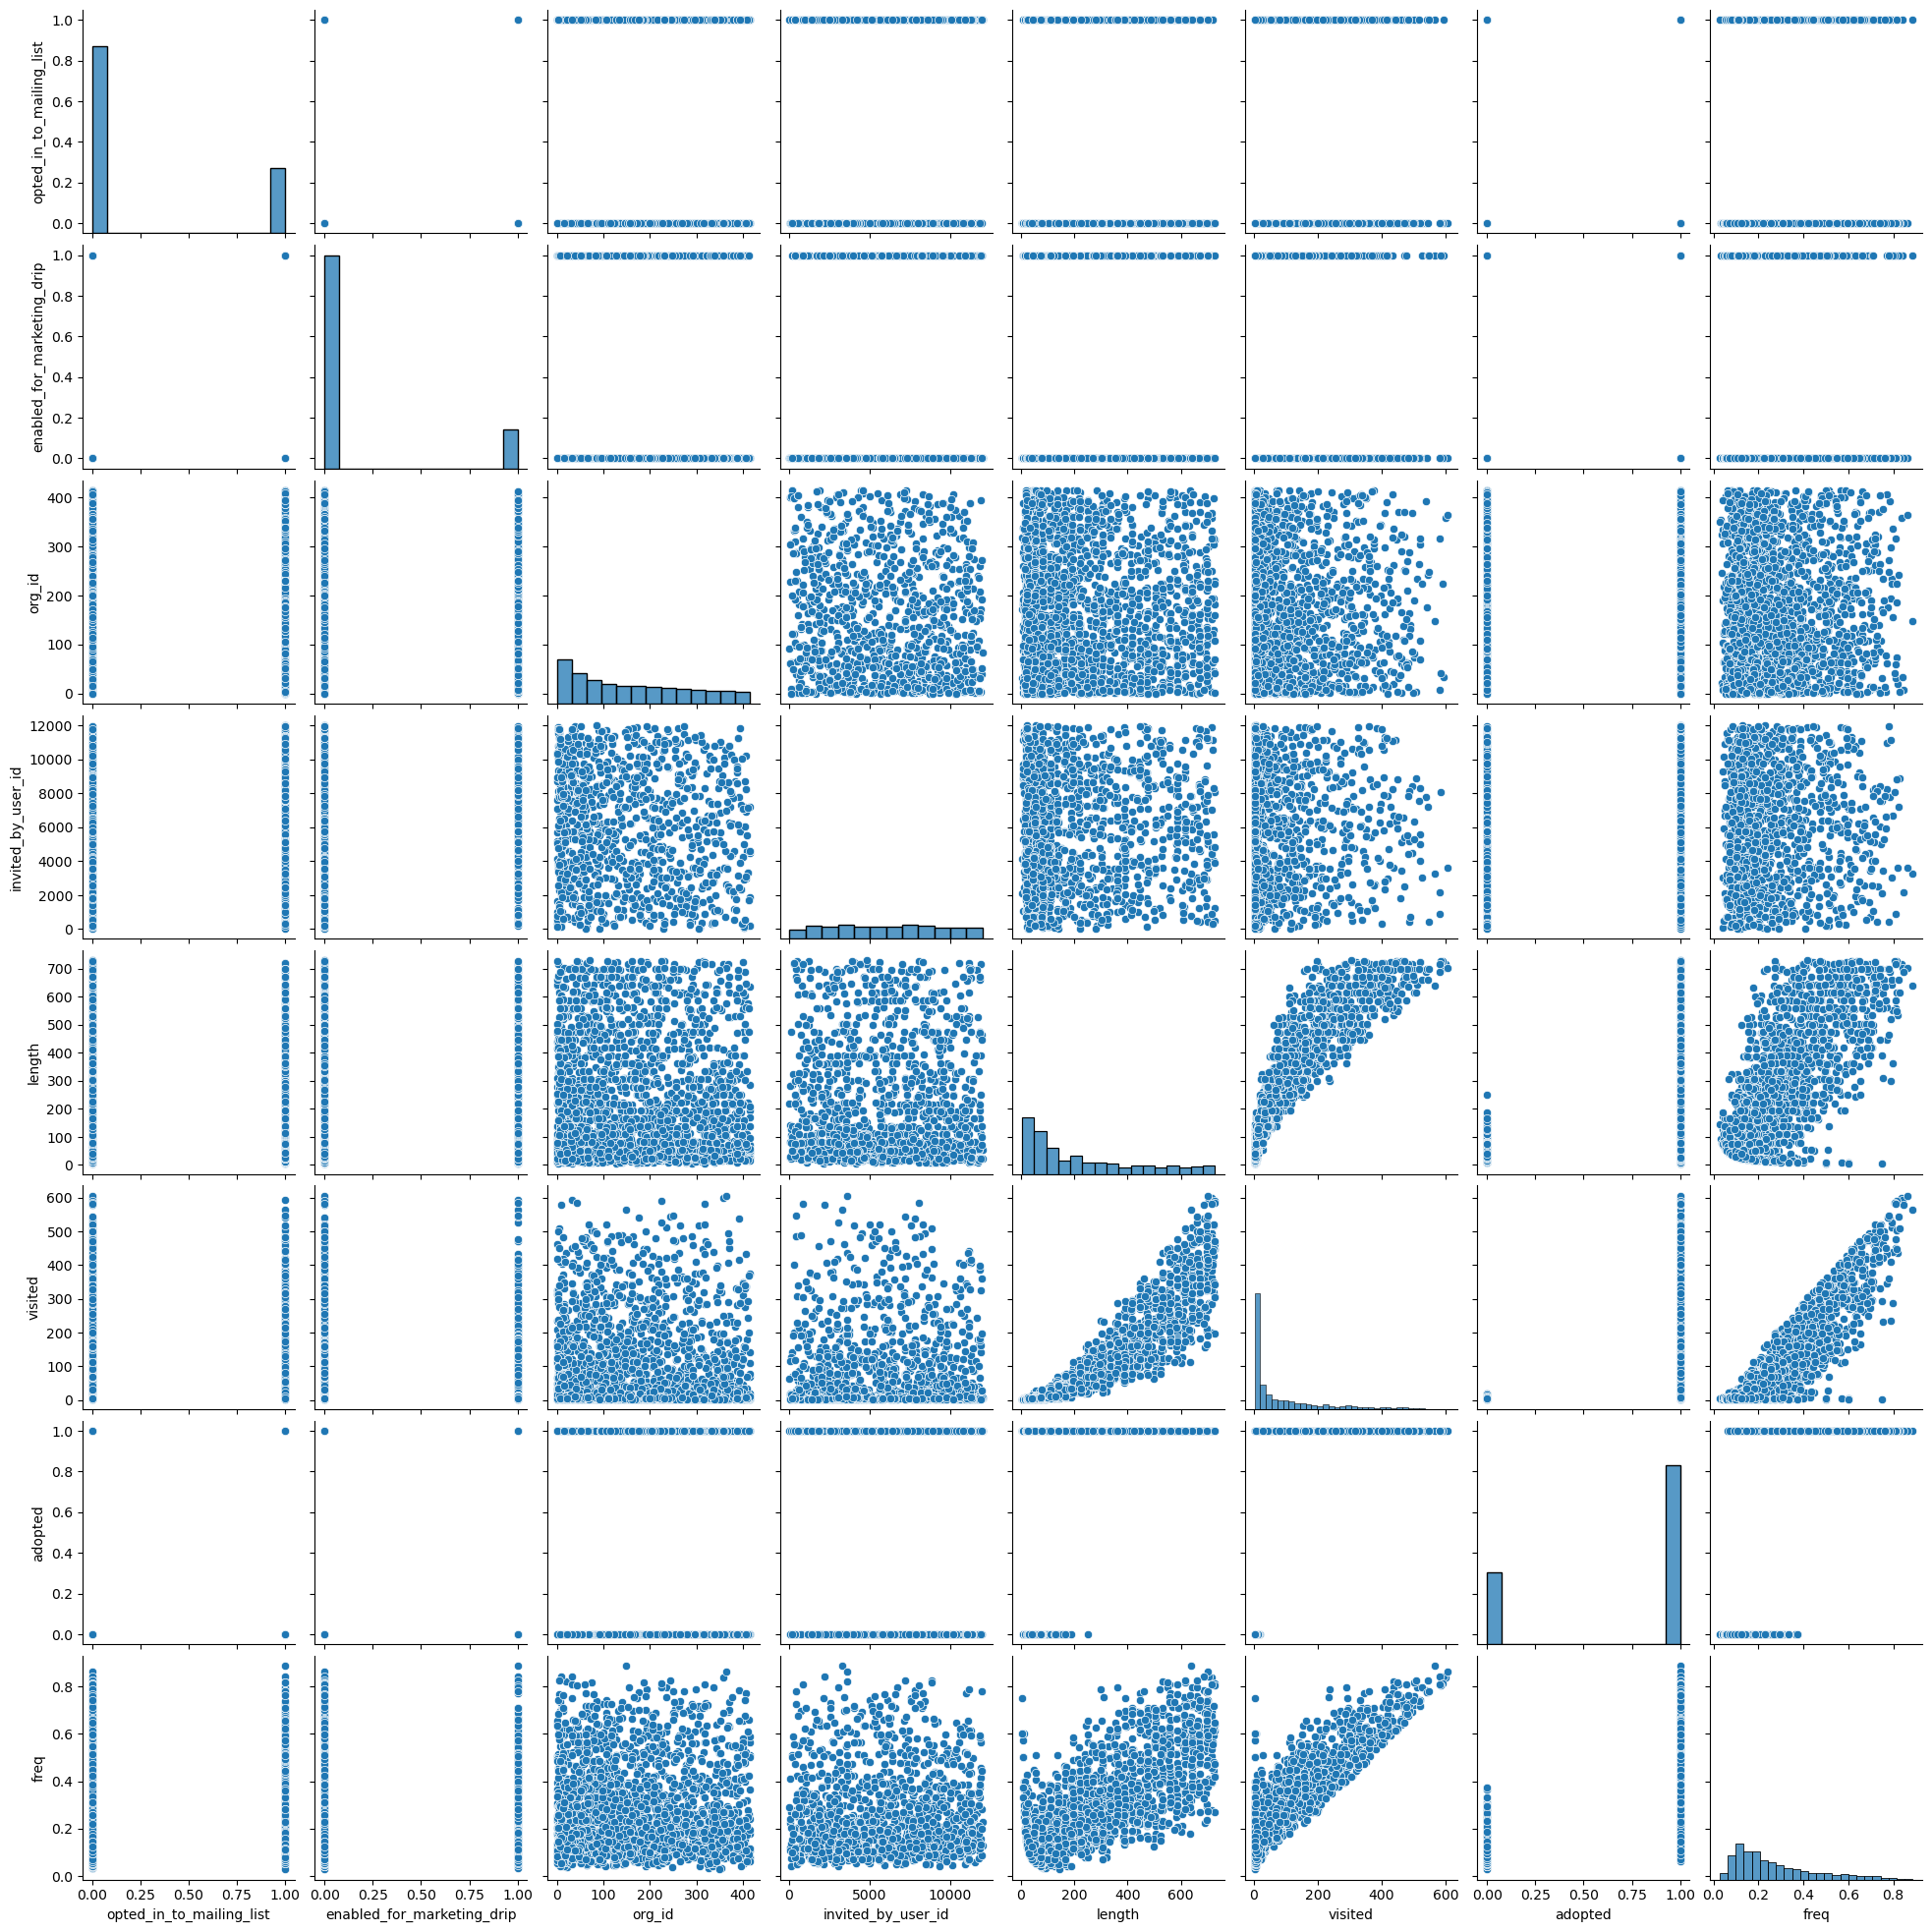

In [33]:
sns.pairplot(df)
plt.show()

In [34]:
corr = df.select_dtypes(include='number').corr('kendall')
corr

opted_in_to_mailing_list  \
opted_in_to_mailing_list                    1.000000   
enabled_for_marketing_drip                  0.488276   
length                                     -0.001076   
visited                                     0.008818   
adopted                                     0.004719   
freq                                        0.033505   

                            enabled_for_marketing_drip    length   visited  \
opted_in_to_mailing_list                      0.488276 -0.001076  0.008818   
enabled_for_marketing_drip                    1.000000  0.005561  0.003836   
length                                        0.005561  1.000000  0.829691   
visited                                       0.003836  0.829691  1.000000   
adopted                                      -0.005425  0.548773  0.614215   
freq                                         -0.002921  0.438522  0.628234   

                             adopted      freq  
opted_in_to_mailing_list    0.004719  0.033505  
enabled_for_marketing_drip -0.005425 -0.002921  
length                      0.548773  0.438522  
visited                     0.614215  0.628234  
adopted                     1.000000  0.478355  
freq                        0.478355  1.000000

In [35]:
fig = px.imshow(corr)
fig.show()

In [36]:
fig = px.scatter(x=df.visited/df.length, y=df.adopted)
fig.show()

In [37]:
fig = px.scatter(df, x='visited', y='adopted')
fig.show()

In [38]:
source = df.groupby('creation_source', as_index=False).agg(avg = ('adopted','mean'), sd = ('adopted','std'))
fig = px.bar(source, x='creation_source', y='avg')
fig.show()

In [39]:
org = df.groupby('org_id', as_index=False).agg(avg = ('adopted','mean'), sd = ('adopted','std'))
fig = px.scatter(org, x='org_id', y='avg')
fig.show()

In [40]:
invite = df.groupby('invited_by_user_id', as_index=False).agg(avg = ('adopted','mean'), sd = ('adopted','std'))
fig = px.scatter(invite, x='invited_by_user_id', y='avg')
fig.show()

In [41]:
X = df.drop('adopted', axis=1)
y = df.adopted

In [42]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ("oh", OneHotEncoder(drop='first', handle_unknown="ignore"), ['creation_source']),
        ("target", TargetEncoder(random_state=0), ['org_id', 'invited_by_user_id'])],
    remainder = 'passthrough')

In [44]:
def xgb_eval(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    
    xgb_param_grid = {'objective':'binary:logistic', 'n_estimators':n_estimators, 'max_depth':max_depth,
                      'learning_rate':learning_rate, 'gamma':gamma, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                      'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight}
    steps = [('prep', preprocessor), ('xgb', xgb.XGBClassifier(**xgb_param_grid))]
    pipeline =  Pipeline(steps)
    
    score = cross_val_score(pipeline, X, y, scoring='f1', cv=kf)
    return score.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=0)
xgb_study = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study.optimize(xgb_eval, n_trials=1000)

[I 2024-03-07 18:24:31,358] A new study created in memory with name: no-name-f5461cbb-8789-409c-ba9b-5e4a7bf04e62
[I 2024-03-07 18:24:32,349] Trial 0 finished with value: 0.9430157853844726 and parameters: {'n_estimators': 320, 'max_depth': 15, 'learning_rate': 0.6027673484378832, 'gamma': 0.5448831829968969, 'reg_alpha': 0.4236547993389047, 'reg_lambda': 0.6458941130666561, 'subsample': 0.4432113391500656, 'colsample_bytree': 0.892855270774259, 'min_child_weight': 9.64026132896019}. Best is trial 0 with value: 0.9430157853844726.
[I 2024-03-07 18:24:32,750] Trial 1 finished with value: 0.9360500604461321 and parameters: {'n_estimators': 253, 'max_depth': 17, 'learning_rate': 0.5288996308037069, 'gamma': 0.5680445610939323, 'reg_alpha': 0.925596638292661, 'reg_lambda': 0.07103605819788694, 'subsample': 0.0962580067045253, 'colsample_bytree': 0.030016213465922464, 'min_child_weight': 8.342936470924586}. Best is trial 0 with value: 0.9430157853844726.
[I 2024-03-07 18:24:33,625] Trial 2 

[I 2024-03-07 18:24:54,670] Trial 19 finished with value: 0.947977802368726 and parameters: {'n_estimators': 107, 'max_depth': 20, 'learning_rate': 0.30703457947458823, 'gamma': 0.15956364723986183, 'reg_alpha': 0.8062660360535459, 'reg_lambda': 0.701041020476274, 'subsample': 0.6699634143516208, 'colsample_bytree': 0.7949080188919623, 'min_child_weight': 2.2229850366171515}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:24:55,429] Trial 20 finished with value: 0.9529317405141638 and parameters: {'n_estimators': 211, 'max_depth': 16, 'learning_rate': 0.12690887480283325, 'gamma': 0.0018359877832377358, 'reg_alpha': 0.566937289046421, 'reg_lambda': 0.6118337494655869, 'subsample': 0.8669213409360693, 'colsample_bytree': 0.2357032685980333, 'min_child_weight': 3.827266960980546}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:24:57,331] Trial 21 finished with value: 0.9524175762721793 and parameters: {'n_estimators': 325, 'max_depth': 10, 'learning_ra

[I 2024-03-07 18:25:16,001] Trial 39 finished with value: 0.9480212824607925 and parameters: {'n_estimators': 308, 'max_depth': 12, 'learning_rate': 0.3469130977829461, 'gamma': 0.10613266905690447, 'reg_alpha': 0.2499055532743698, 'reg_lambda': 0.7389323727433618, 'subsample': 0.9295239576916935, 'colsample_bytree': 0.6375181200148285, 'min_child_weight': 1.3165679682777829}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:25:16,998] Trial 40 finished with value: 0.9501971039282594 and parameters: {'n_estimators': 258, 'max_depth': 9, 'learning_rate': 0.10035311051347752, 'gamma': 0.335922161565863, 'reg_alpha': 0.17104134787878844, 'reg_lambda': 0.392134212332902, 'subsample': 0.3905539083467589, 'colsample_bytree': 0.55475157591305, 'min_child_weight': 2.4518633037241413}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:25:18,747] Trial 41 finished with value: 0.9533207001340616 and parameters: {'n_estimators': 377, 'max_depth': 7, 'learning_rate': 

[I 2024-03-07 18:25:33,863] Trial 59 finished with value: 0.9468519719393477 and parameters: {'n_estimators': 199, 'max_depth': 20, 'learning_rate': 0.6335232866922857, 'gamma': 0.2509493697087441, 'reg_alpha': 0.4746773413436305, 'reg_lambda': 0.7066849589586951, 'subsample': 0.6715920971267616, 'colsample_bytree': 0.3239233740935669, 'min_child_weight': 1.5287969447489647}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:25:34,439] Trial 60 finished with value: 0.9511210468052079 and parameters: {'n_estimators': 124, 'max_depth': 8, 'learning_rate': 0.2225397290366467, 'gamma': 0.21594985449000764, 'reg_alpha': 0.752992008563373, 'reg_lambda': 0.7961364635895487, 'subsample': 0.843802213829762, 'colsample_bytree': 0.4364435207342995, 'min_child_weight': 3.5116608261549747}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:25:36,508] Trial 61 finished with value: 0.9526513715578316 and parameters: {'n_estimators': 412, 'max_depth': 7, 'learning_rate': 

[I 2024-03-07 18:25:57,512] Trial 79 finished with value: 0.9499867879649326 and parameters: {'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.020853403594832592, 'gamma': 0.04880753947194163, 'reg_alpha': 0.5521041741686672, 'reg_lambda': 0.7535378298285345, 'subsample': 0.551043717053069, 'colsample_bytree': 0.32373564970086255, 'min_child_weight': 4.825265885658507}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:25:59,070] Trial 80 finished with value: 0.9508167747891083 and parameters: {'n_estimators': 423, 'max_depth': 19, 'learning_rate': 0.08646206648247691, 'gamma': 0.43903680154215374, 'reg_alpha': 0.790638605993758, 'reg_lambda': 0.6143238227240232, 'subsample': 0.6935920714400021, 'colsample_bytree': 0.4949565755853656, 'min_child_weight': 4.332026876372304}. Best is trial 15 with value: 0.955521519285717.
[I 2024-03-07 18:26:00,382] Trial 81 finished with value: 0.9530171028466752 and parameters: {'n_estimators': 368, 'max_depth': 6, 'learning_rate

[I 2024-03-07 18:26:25,538] Trial 99 finished with value: 0.9484267479262357 and parameters: {'n_estimators': 296, 'max_depth': 11, 'learning_rate': 0.708398394909337, 'gamma': 0.5434954647485608, 'reg_alpha': 0.38626886603721794, 'reg_lambda': 0.7299403168284866, 'subsample': 0.921796027073948, 'colsample_bytree': 0.7071892751326321, 'min_child_weight': 2.9818169539132686}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:26:27,053] Trial 100 finished with value: 0.9516753003591821 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.04916066792553281, 'gamma': 0.49108043889189934, 'reg_alpha': 0.43740707726773187, 'reg_lambda': 0.6551230539030514, 'subsample': 0.9806927779065021, 'colsample_bytree': 0.6610985794030252, 'min_child_weight': 3.71731558767192}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:26:28,511] Trial 101 finished with value: 0.955495450626984 and parameters: {'n_estimators': 265, 'max_depth': 10, 'learning_ra

[I 2024-03-07 18:26:52,399] Trial 119 finished with value: 0.9523360527660258 and parameters: {'n_estimators': 168, 'max_depth': 18, 'learning_rate': 0.1200105102671904, 'gamma': 0.5502383199668298, 'reg_alpha': 0.29049593480188257, 'reg_lambda': 0.30662054057442084, 'subsample': 0.9325112356948954, 'colsample_bytree': 0.762921189190826, 'min_child_weight': 4.165310822221808}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:26:53,399] Trial 120 finished with value: 0.9532879573092939 and parameters: {'n_estimators': 187, 'max_depth': 8, 'learning_rate': 0.042660444060134056, 'gamma': 0.8798909861466296, 'reg_alpha': 0.33220169118768195, 'reg_lambda': 0.017818609286933934, 'subsample': 0.9687761399686016, 'colsample_bytree': 0.4732358535055456, 'min_child_weight': 3.073376650232566}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:26:54,743] Trial 121 finished with value: 0.9536116668826043 and parameters: {'n_estimators': 237, 'max_depth': 10, 'learn

[I 2024-03-07 18:27:15,745] Trial 139 finished with value: 0.9484843029802464 and parameters: {'n_estimators': 215, 'max_depth': 10, 'learning_rate': 0.48525855589662775, 'gamma': 0.4340905546275021, 'reg_alpha': 0.6785003255408958, 'reg_lambda': 0.7230975691956464, 'subsample': 0.16631199834118537, 'colsample_bytree': 0.5612987021316238, 'min_child_weight': 2.855024447973526}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:27:17,025] Trial 140 finished with value: 0.9522188699068639 and parameters: {'n_estimators': 251, 'max_depth': 9, 'learning_rate': 0.06320038560425098, 'gamma': 0.0862495303062592, 'reg_alpha': 0.6317226434868399, 'reg_lambda': 0.7810026660667927, 'subsample': 0.9305085748117022, 'colsample_bytree': 0.6028064081833499, 'min_child_weight': 3.2891288700820356}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:27:19,778] Trial 141 finished with value: 0.9528820562976833 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learnin

[I 2024-03-07 18:27:43,683] Trial 159 finished with value: 0.9481476470787115 and parameters: {'n_estimators': 134, 'max_depth': 8, 'learning_rate': 0.0010891038654955443, 'gamma': 0.17332210693208666, 'reg_alpha': 0.6980421756111754, 'reg_lambda': 0.6975102215394107, 'subsample': 0.48525485063493307, 'colsample_bytree': 0.5309038313643585, 'min_child_weight': 9.956441483928119}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:27:44,480] Trial 160 finished with value: 0.9489281809496554 and parameters: {'n_estimators': 160, 'max_depth': 10, 'learning_rate': 0.3572957859223638, 'gamma': 0.22750415192028967, 'reg_alpha': 0.6640097928035937, 'reg_lambda': 0.7214661740994323, 'subsample': 0.8824519094621782, 'colsample_bytree': 0.43262608270404224, 'min_child_weight': 1.4095569857768222}. Best is trial 93 with value: 0.9555787371739353.
[I 2024-03-07 18:27:46,082] Trial 161 finished with value: 0.9517286295892087 and parameters: {'n_estimators': 269, 'max_depth': 17, 'lea

[I 2024-03-07 18:28:05,973] Trial 178 finished with value: 0.9533013773316155 and parameters: {'n_estimators': 167, 'max_depth': 20, 'learning_rate': 0.03554383045273679, 'gamma': 0.01563443066154826, 'reg_alpha': 0.5531738321981244, 'reg_lambda': 0.8055462739909857, 'subsample': 0.729479234164038, 'colsample_bytree': 0.7816255496032233, 'min_child_weight': 3.5395076977461772}. Best is trial 173 with value: 0.9560018243298959.
[I 2024-03-07 18:28:07,101] Trial 179 finished with value: 0.9530415677627824 and parameters: {'n_estimators': 210, 'max_depth': 19, 'learning_rate': 0.06376204214385953, 'gamma': 0.03928317564905625, 'reg_alpha': 0.5989712389199404, 'reg_lambda': 0.7971408981316701, 'subsample': 0.7606294021041556, 'colsample_bytree': 0.6599031236320178, 'min_child_weight': 2.9524773531954076}. Best is trial 173 with value: 0.9560018243298959.
[I 2024-03-07 18:28:08,045] Trial 180 finished with value: 0.9523338201697131 and parameters: {'n_estimators': 183, 'max_depth': 20, 'lea

In [ ]:
best_trial = xgb_study.best_trial
best_params = best_trial.params
best_params['objective'] = 'binary:logistic'
best_params

In [ ]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif)), ('xgb', xgb.XGBClassifier(**best_params))]
pipeline =  Pipeline(steps)
k = [k for k in range(1, 11)]
parameters = {'selectkbest__k':k}
xgb_mi_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=kf)
xgb_mi_cv.fit(X, y)

In [ ]:
xgb_mi_cv.best_score_, xgb_mi_cv.best_params_

In [ ]:
score_mean = xgb_mi_cv.cv_results_['mean_test_score']
score_std = xgb_mi_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb',
                  yaxis_title='CV score (auc)', width=950, height=500)

fig.show('png')

In [ ]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif, k=6)), ('xgb', xgb.XGBClassifier(**best_params))]
pipeline =  Pipeline(steps)
pipeline.fit(X, y)

In [ ]:
idx = pipeline.named_steps.selectkbest.get_support()
idx

In [ ]:
importances = pipeline.named_steps.xgb.feature_importances_
importance_xgb_mi = pd.DataFrame({'feature': pipeline.named_steps.prep.get_feature_names_out()[idx], 
                              'importance': importances})
importance_xgb_mi.feature = importance_xgb_mi.feature.str.replace('.*__','', regex=True)
top_xgb_mi = importance_xgb_mi.sort_values('importance', ascending=False)
top_xgb_mi

In [ ]:
fig = px.bar(x=top_xgb_mi.importance[::-1], y=top_xgb_mi.feature[::-1], text_auto='.2', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('png')